In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from scipy.stats import norm
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers


In [3]:
def load_data(batch_size):   #加载数据集并预处理
    
    (train_data,train_labels),(test_data,test_labels) = tf.keras.datasets.mnist.load_data()
    
    train_data = train_data.reshape(-1,784).astype('float32') / 255.
    test_data = test_data.reshape(-1,784).astype('float32') / 255.
    
    train_data = tf.data.Dataset.from_tensor_slices(train_data).batch(batch_size)   #数据分批
    train_labels = tf.data.Dataset.from_tensor_slices(train_labels).batch(batch_size)
    train_dataset = tf.data.Dataset.zip((train_data,train_labels)).shuffle(60000)   #数据打乱
    
    test_data = tf.data.Dataset.from_tensor_slices(test_data).batch(batch_size)
    test_labels = tf.data.Dataset.from_tensor_slices(test_labels).batch(batch_size)
    test_dataset = tf.data.Dataset.zip((test_data,test_labels)).shuffle(10000)
    
    return train_dataset,test_dataset

In [4]:
class VAE(tf.keras.Model):
    def __init__(self,latent_dim):
        super(VAE,self).__init__()
        self.latent_dim = latent_dim
        self.epsilon_std = 1.0
        self.Encoder = tf.keras.models.Sequential([   #编码器网络
            layers.Dense(256,activation='relu'),
            layers.Dense(2)
        ])
        self.Decoder = tf.keras.models.Sequential([   #解码器网络
            layers.Dense(256, activation='relu'),
            layers.Dense(784,activation = 'sigmoid')
        ])
        
    def encode(self,x):
        z_mean = self.Encoder(x)   #均值
        z_log_var = self.Encoder(x)   #方差
        return z_mean, z_log_var
    
    def sampling(self, z_mean, z_log_var):
        z_mean, z_log_var = z_mean, z_log_var
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], self.latent_dim), mean=0.,stddev=self.epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    def decode(self,z):
        x_decoded_mean = self.Decoder(z)
        return x_decoded_mean

In [5]:
def compute_loss(model,x):   #损失函数
    z_mean, z_log_var = model.encode(x)
    z = model.sampling(z_mean,z_log_var)
    x_decoded_mean = model.decode(z)
    
    #loss
    xent_loss = 784 * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    
    return vae_loss

def compute_gradient(model,x):   #计算梯度
    with tf.GradientTape() as tape:
        loss = compute_loss(model,x)
    gradient = tape.gradient(loss,model.trainable_variables)
    return gradient,loss


def update(optimizer,gradients,variables):   #梯度更新
    optimizer.apply_gradients(zip(gradients,variables))

In [6]:
train_dataset,test_dataset = load_data(1000)
model = VAE(2)
optimizer = tf.keras.optimizers.Adam(0.01)
for epoch in range(10):
    start = time.time()
    last_loss = 0
    for train_x,_ in train_dataset:
        gradients,loss = compute_gradient(model,train_x)   #计算梯度
        update(optimizer,gradients,model.trainable_variables)   #更新梯度
        last_loss = loss
    print ('Epoch {},loss: {}'.format(epoch,last_loss))

Epoch 0,loss: 185.00611877441406
Epoch 1,loss: 181.779052734375
Epoch 2,loss: 181.63121032714844
Epoch 3,loss: 178.230712890625
Epoch 4,loss: 175.22328186035156
Epoch 5,loss: 175.69309997558594
Epoch 6,loss: 173.57022094726562
Epoch 7,loss: 179.91880798339844
Epoch 8,loss: 170.93853759765625
Epoch 9,loss: 172.385498046875


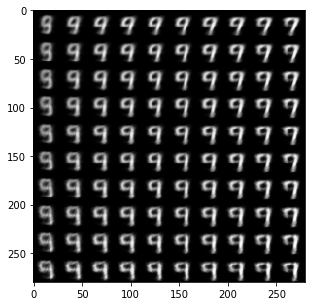

In [11]:
n = 10   #显示的数量为10x10
img_size = 28   #定义图片大小
figure = np.zeros((img_size * n, img_size * n))   #空矩阵，用于显示图像
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))   #基于正态分布创建分位数
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, y in enumerate(grid_x):    
    for j, x in enumerate(grid_y):
        z_sample = np.array([[x, y]])   #采样一个z隐变量
        x_decoded = model.decode(z_sample).numpy()   #根据z隐变量生成图像
        digit = x_decoded[0].reshape(img_size, img_size)   #转化为2维图像
        #将结果放入空矩阵中方便显示
        figure[i * img_size: (i + 1) * img_size, j * img_size: (j + 1) * img_size] = digit
#显示图像
plt.figure(figsize=(5, 5))
plt.imshow(figure, cmap='Greys_r')
plt.show()